# ngram 기반 문장 유사도 분석

200326

중복뉴스 제거를 위해

In [161]:
import re, os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from konlpy.tag import Okt
okt=Okt()

In [178]:
sentences = ['마루웹호스팅, 공격자와 협상에도 데이터 복구 \'차질\'',
             '안랩, 이력서로 위장해 유포되는 넴티 랜섬웨어 주의 당부'
             '이번에도 호스팅 업체…잇따른 랜섬웨어 감염',
             '웹 호스팅 업체 마루인터넷, 랜섬웨어에 감염',
             '웹호스팅 업체 ‘마루호스팅’ 랜섬웨어 공격 당해... 해커와 협상 중',
             '웹호스팅 업체 \'마루인터넷\', 랜섬웨어 감염…"공격자와 협상 중"',
             '''해커와 협상을?" 웹호스팅 업체 또 해킹에 당했다''',
             '"마스크 생산기업, 랜섬웨어 걸리면…"',
             '코로나19 악용한 랜섬웨어 주의보',
             'KISA, 코로나19 이슈 악용한 랜섬웨어 공격 대비 보안 강화 당부',
             '"코로나19" 악용한 랜섬웨어 주의보',
             '코로나19 악용하는 사이버 공격 주의']
sentences

["마루웹호스팅, 공격자와 협상에도 데이터 복구 '차질'",
 '안랩, 이력서로 위장해 유포되는 넴티 랜섬웨어 주의 당부이번에도 호스팅 업체…잇따른 랜섬웨어 감염',
 '웹 호스팅 업체 마루인터넷, 랜섬웨어에 감염',
 '웹호스팅 업체 ‘마루호스팅’ 랜섬웨어 공격 당해... 해커와 협상 중',
 '웹호스팅 업체 \'마루인터넷\', 랜섬웨어 감염…"공격자와 협상 중"',
 '해커와 협상을?" 웹호스팅 업체 또 해킹에 당했다',
 '"마스크 생산기업, 랜섬웨어 걸리면…"',
 '코로나19 악용한 랜섬웨어 주의보',
 'KISA, 코로나19 이슈 악용한 랜섬웨어 공격 대비 보안 강화 당부',
 '"코로나19" 악용한 랜섬웨어 주의보',
 '코로나19 악용하는 사이버 공격 주의']

In [179]:
## functions
def _rouge_clean(s):
    return re.sub(r'[^a-zA-Z0-9ㄱ-ㅣ가-힣 ]', '', s)

def _get_ngrams(n, text):
    """Calcualtes n-grams.

    Args:
      n: which n-grams to calculate
      text: An array of tokens

    Returns:
      A set of n-grams
    """
    ngram_set = set()
    text_length = len(text)
    max_index_ngram_start = text_length - n
    for i in range(max_index_ngram_start + 1):
        ngram_set.add(tuple(text[i:i + n]))
    return ngram_set


def _get_word_ngrams(n, sentence):
    """Calculates word n-grams for multiple sentences.
    """
    assert len(sentence) > 0
    assert n > 0

    sentence = re.sub(r'[^a-zA-Z0-9ㄱ-ㅣ가-힣 ]', '', sentence )
    
    words = sentence.split()
    return _get_ngrams(n, words)


def cal_rouge(evaluated_ngrams, reference_ngrams):
    # N-gram중 몇개가 겹치는가!
    
    reference_count = len(reference_ngrams)
    evaluated_count = len(evaluated_ngrams)

    overlapping_ngrams = evaluated_ngrams.intersection(reference_ngrams)
    overlapping_count = len(overlapping_ngrams)

    if evaluated_count == 0:
        precision = 0.0
    else:
        precision = overlapping_count / evaluated_count

    if reference_count == 0:
        recall = 0.0
    else:
        recall = overlapping_count / reference_count

    f1_score = 2.0 * ((precision * recall) / (precision + recall + 1e-8))
    return {"f": f1_score, "p": precision, "r": recall}


def get_rouge(sentence_1, sentence_2):
    # input : sentence_1 : 그냥 일반 문장, '~~~'
    # output: total rouge
    
    ## 1. 형태소 기준 tokenize, ' ' 삽입
    #     '웹 호스팅 업체 마루인터넷, 랜섬웨어에 감염''
    #  -> '웹 호스팅 업체 마루 인터넷 , 랜섬웨어 에 감염'
    sentence_1 = ' '.join(okt.morphs(sentence_1))
    sentence_2 = ' '.join(okt.morphs(sentence_2))
    
    ## 2. get n-gram!!
    # {('공격', '당해', '해커'), ('웹호스팅', '업체', '마루'), ('마루', '호스팅', '랜섬'), ('호스팅', '랜섬', '웨어'), ('웨어', '공격', '당해'), ('와', '협상', '중'), ('당해', '해커', '와'), ('해커', '와', '협상'), ('업체', '마루', '호스팅'), ('랜섬', '웨어', '공격')}
    sentence_1_1grams = _get_word_ngrams(1, sentence_1)
    sentence_1_2grams = _get_word_ngrams(2, sentence_1)
    sentence_1_3grams = _get_word_ngrams(3, sentence_1)
    sentence_2_1grams = _get_word_ngrams(1, sentence_2)
    sentence_2_2grams = _get_word_ngrams(2, sentence_2)
    sentence_2_3grams = _get_word_ngrams(3, sentence_2)

    ## 3. ROUGE 구하기
    ROUGE_1 = cal_rouge(sentence_1_1grams, sentence_2_1grams)['f']
    ROUGE_2 = cal_rouge(sentence_1_2grams, sentence_2_2grams)['f']
    ROUGE_3 = cal_rouge(sentence_1_3grams, sentence_2_3grams)['f']

    weight_1, weight_2, weight_3 = 1,1,1
    Total_Rouge = weight_1*ROUGE_1 + weight_2*ROUGE_2 + weight_3*ROUGE_3
    
    print('ROUGE_1/2/3/Total : %.2f / %.2f / %.2f / %.2f' % (ROUGE_1, ROUGE_2, ROUGE_3, Total_Rouge))
    
    return round(Total_Rouge / (weight_1 + weight_2 + weight_3), 2)  # 최대값이 3인데 1로 normalize 하기 위해


In [180]:
## 여러 문장간 ROUGE 값 구하기
np.zeros([len(sentences), len(sentences)])
for idx_1, sentence_1 in enumerate(sentences):
    for idx_2, sentence_2 in enumerate(sentences):
        ROUGE = get_rouge(sentence_1, sentence_2)
        rouge_matrix[idx_1, idx_2] = ROUGE

ROUGE_1/2/3/Total : 1.00 / 1.00 / 1.00 / 3.00
ROUGE_1/2/3/Total : 0.07 / 0.00 / 0.00 / 0.07
ROUGE_1/2/3/Total : 0.11 / 0.00 / 0.00 / 0.11
ROUGE_1/2/3/Total : 0.45 / 0.10 / 0.00 / 0.55
ROUGE_1/2/3/Total : 0.55 / 0.30 / 0.22 / 1.07
ROUGE_1/2/3/Total : 0.30 / 0.11 / 0.00 / 0.41
ROUGE_1/2/3/Total : 0.00 / 0.00 / 0.00 / 0.00
ROUGE_1/2/3/Total : 0.00 / 0.00 / 0.00 / 0.00
ROUGE_1/2/3/Total : 0.09 / 0.00 / 0.00 / 0.09
ROUGE_1/2/3/Total : 0.00 / 0.00 / 0.00 / 0.00
ROUGE_1/2/3/Total : 0.12 / 0.00 / 0.00 / 0.12
ROUGE_1/2/3/Total : 0.07 / 0.00 / 0.00 / 0.07
ROUGE_1/2/3/Total : 1.00 / 1.00 / 1.00 / 3.00
ROUGE_1/2/3/Total : 0.23 / 0.08 / 0.00 / 0.31
ROUGE_1/2/3/Total : 0.27 / 0.07 / 0.00 / 0.34
ROUGE_1/2/3/Total : 0.27 / 0.14 / 0.07 / 0.48
ROUGE_1/2/3/Total : 0.07 / 0.00 / 0.00 / 0.07
ROUGE_1/2/3/Total : 0.17 / 0.09 / 0.00 / 0.25
ROUGE_1/2/3/Total : 0.16 / 0.08 / 0.00 / 0.24
ROUGE_1/2/3/Total : 0.19 / 0.07 / 0.00 / 0.26
ROUGE_1/2/3/Total : 0.16 / 0.08 / 0.00 / 0.24
ROUGE_1/2/3/Total : 0.08 / 0.00 / 

In [182]:
rouge_matrix

array([[1.  , 0.02, 0.04, 0.18, 0.36, 0.14, 0.  , 0.  , 0.03, 0.  , 0.04,
        0.04],
       [0.02, 1.  , 0.1 , 0.11, 0.16, 0.02, 0.08, 0.08, 0.09, 0.08, 0.03,
        0.03],
       [0.04, 0.1 , 1.  , 0.14, 0.25, 0.07, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  ],
       [0.18, 0.11, 0.14, 1.  , 0.47, 0.29, 0.12, 0.11, 0.17, 0.11, 0.04,
        0.04],
       [0.36, 0.16, 0.25, 0.47, 1.  , 0.19, 0.12, 0.11, 0.11, 0.11, 0.04,
        0.04],
       [0.14, 0.02, 0.07, 0.29, 0.19, 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  ],
       [0.  , 0.08, 0.  , 0.12, 0.12, 0.  , 1.  , 0.16, 0.11, 0.16, 0.  ,
        0.  ],
       [0.  , 0.08, 0.  , 0.11, 0.11, 0.  , 0.16, 1.  , 0.43, 1.  , 0.32,
        0.32],
       [0.03, 0.09, 0.  , 0.17, 0.11, 0.  , 0.11, 0.43, 1.  , 0.43, 0.17,
        0.28],
       [0.  , 0.08, 0.  , 0.11, 0.11, 0.  , 0.16, 1.  , 0.43, 1.  , 0.32,
        0.17],
       [0.04, 0.03, 0.  , 0.04, 0.04, 0.  , 0.  , 0.32, 0.17, 0.32, 1.  ,
        0.32],
       [0.04, 0.03, 0

In [183]:
sentences = ['마루웹호스팅, 공격자와 협상에도 데이터 복구 \'차질\'',
             '안랩, 이력서로 위장해 유포되는 넴티 랜섬웨어 주의 당부'
             '이번에도 호스팅 업체…잇따른 랜섬웨어 감염',
             '웹 호스팅 업체 마루인터넷, 랜섬웨어에 감염',
             '웹호스팅 업체 ‘마루호스팅’ 랜섬웨어 공격 당해... 해커와 협상 중',
             '웹호스팅 업체 \'마루인터넷\', 랜섬웨어 감염…"공격자와 협상 중"',
             '''해커와 협상을?" 웹호스팅 업체 또 해킹에 당했다''',
             '"마스크 생산기업, 랜섬웨어 걸리면…"',
             '코로나19 악용한 랜섬웨어 주의보',
             '''KISA, "코로나19" 악용한 랜섬웨어 공격…"철저히 대비 해야"''',
             'KISA, 코로나19 이슈 악용한 랜섬웨어 공격 대비 보안 강화 당부',
             '"코로나19" 악용한 랜섬웨어 주의보']
sentences

["마루웹호스팅, 공격자와 협상에도 데이터 복구 '차질'",
 '안랩, 이력서로 위장해 유포되는 넴티 랜섬웨어 주의 당부이번에도 호스팅 업체…잇따른 랜섬웨어 감염',
 '웹 호스팅 업체 마루인터넷, 랜섬웨어에 감염',
 '웹호스팅 업체 ‘마루호스팅’ 랜섬웨어 공격 당해... 해커와 협상 중',
 '웹호스팅 업체 \'마루인터넷\', 랜섬웨어 감염…"공격자와 협상 중"',
 '해커와 협상을?" 웹호스팅 업체 또 해킹에 당했다',
 '"마스크 생산기업, 랜섬웨어 걸리면…"',
 '코로나19 악용한 랜섬웨어 주의보',
 'KISA, "코로나19" 악용한 랜섬웨어 공격…"철저히 대비 해야"',
 'KISA, 코로나19 이슈 악용한 랜섬웨어 공격 대비 보안 강화 당부',
 '"코로나19" 악용한 랜섬웨어 주의보']

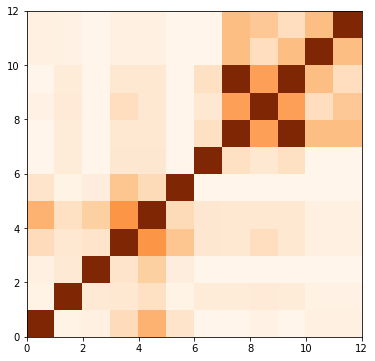

In [184]:
plt.figure(figsize = (6, 6))
plt.pcolor(rouge_matrix,cmap=cm.Oranges)
plt.show()

<BarContainer object of 12 artists>

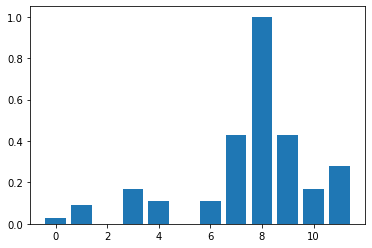

In [185]:
plt.bar(np.arange(len(rouge_matrix)), rouge_matrix[8, :])

<BarContainer object of 12 artists>

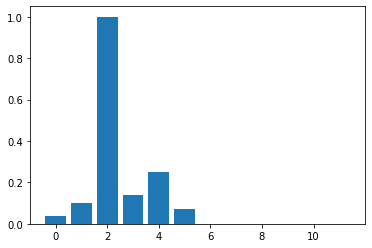

In [186]:
plt.bar(np.arange(len(rouge_matrix)), rouge_matrix[2, :])